# Computer Vision 2024 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question is a more challenging classification experiment on a larger dataset. Answer the questions in separate Python notebooks.

## Question 1: A simple classifier, 20 marks

For this exercise, we provide demo code showing how to train a network on a small dataset called [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

**Q1.1 (1 point)**

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

**Q1.2 (2 points)** 

Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   |      |
|0.1|          |
|0.01|         |
|0.001  |        |


**Q1.3 (3 points)** 

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loass curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |      |     |
|0.1|          |    |
|0.01|         |    |
|0.001  |        |     |


**Q1.4 (2 points)** 

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?


**Q1.5 (5 points)** 

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |      ||
|Deeper|          ||
|Wider|         ||


**Q1.6 (2 points)** 

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

**Q1.7 (5 points)** 

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [2]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

**NOTE**: For consistency with the original data set, we call our validation data "test_data". It is important to keep in mind though that we are using the data for model validation and not for testing the final, trained model (which requires data not used when training the model parameters). 

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

In [5]:
label_defs = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

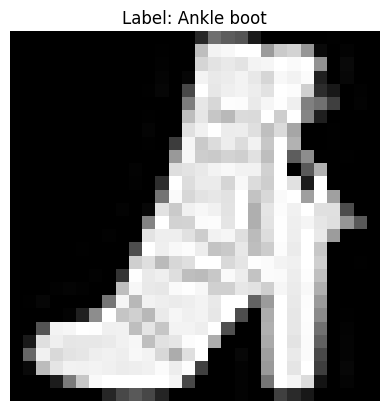

Shape: torch.Size([28, 28])




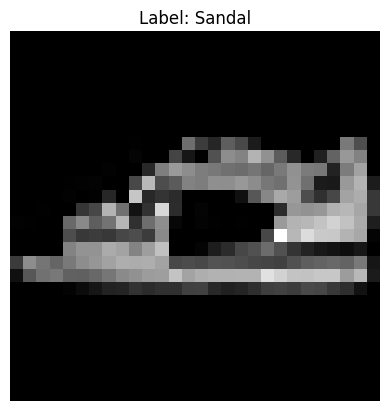

Shape: torch.Size([28, 28])




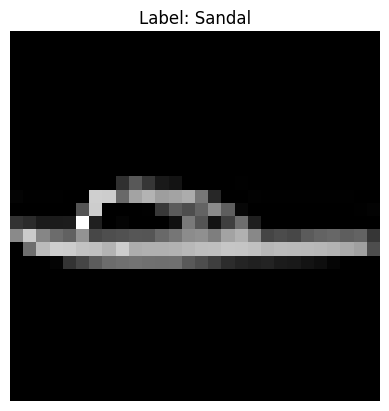

Shape: torch.Size([28, 28])




In [6]:
# Code cell for training image display
images, labels = next(iter(train_dataloader))

import random
training_indices = random.sample(range(batch_size), 3)

training_images = [(images[index][0,:,:], labels[index]) for index in training_indices]

for image in training_images:
    plt.imshow(image[0], cmap="gray")
    plt.title(f"Label: {label_defs[int(image[1])]}")
    plt.axis("off")
    plt.show()
    print(f"Shape: {image[0].shape}")
    print("\n")

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        train_loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = train_loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return train_loss.item()

In [10]:
##Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

In [40]:
#Train and test the model
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 2.293602  [    0/60000]
loss: 2.286292  [ 6400/60000]
loss: 2.264708  [12800/60000]
loss: 2.256611  [19200/60000]
loss: 2.249419  [25600/60000]
loss: 2.218816  [32000/60000]
loss: 2.220648  [38400/60000]
loss: 2.191169  [44800/60000]
loss: 2.187937  [51200/60000]
loss: 2.151143  [57600/60000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 2.150740 

Epoch 2
-------------------------------
loss: 2.158686  [    0/60000]
loss: 2.154022  [ 6400/60000]
loss: 2.090332  [12800/60000]
loss: 2.101459  [19200/60000]
loss: 2.062429  [25600/60000]
loss: 2.000366  [32000/60000]
loss: 2.021152  [38400/60000]
loss: 1.947180  [44800/60000]
loss: 1.947604  [51200/60000]
loss: 1.867701  [57600/60000]
Test Error: 
 Accuracy: 57.5%, Avg loss: 1.871943 

Epoch 3
-------------------------------
loss: 1.904178  [    0/60000]
loss: 1.880013  [ 6400/60000]
loss: 1.752707  [12800/60000]
loss: 1.791105  [19200/60000]
loss: 1.692573  [25600/60000]
loss: 1.637511  [32000/600

## 1.2

Training for 10 epochs with learning rate: 1
Epoch 1
-------------------------------
loss: 2.295444  [    0/60000]
loss: 1.980232  [ 6400/60000]
loss: 1.971453  [12800/60000]
loss: 2.104311  [19200/60000]
loss: 2.313797  [25600/60000]
loss: 2.002636  [32000/60000]
loss: 1.433282  [38400/60000]
loss: 1.805757  [44800/60000]
loss: 1.688983  [51200/60000]
loss: 2.807741  [57600/60000]
Test Error: 
 Accuracy: 13.4%, Avg loss: 1.820219 

Epoch 2
-------------------------------
loss: 1.873500  [    0/60000]
loss: 1.642794  [ 6400/60000]
loss: 1.743324  [12800/60000]
loss: 1.684400  [19200/60000]
loss: 2.207927  [25600/60000]
loss: 2.262850  [32000/60000]
loss: 2.600851  [38400/60000]
loss: 2.002929  [44800/60000]
loss: 1.951202  [51200/60000]
loss: 1.701331  [57600/60000]
Test Error: 
 Accuracy: 20.4%, Avg loss: 1.715072 

Epoch 3
-------------------------------
loss: 1.723304  [    0/60000]
loss: 1.964605  [ 6400/60000]
loss: 1.982199  [12800/60000]
loss: 1.740803  [19200/60000]
loss: 1.709

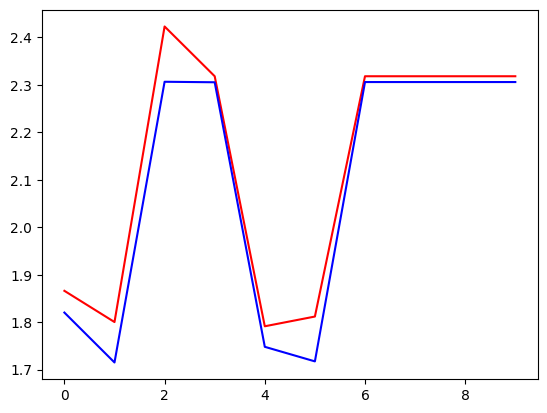

Done!

Training for 10 epochs with learning rate: 0.1
Epoch 1
-------------------------------
loss: 2.314358  [    0/60000]
loss: 0.905528  [ 6400/60000]
loss: 0.577877  [12800/60000]
loss: 0.697705  [19200/60000]
loss: 0.594135  [25600/60000]
loss: 0.509790  [32000/60000]
loss: 0.535337  [38400/60000]
loss: 0.602574  [44800/60000]
loss: 0.604390  [51200/60000]
loss: 0.466300  [57600/60000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.546210 

Epoch 2
-------------------------------
loss: 0.417352  [    0/60000]
loss: 0.450595  [ 6400/60000]
loss: 0.370296  [12800/60000]
loss: 0.421128  [19200/60000]
loss: 0.398313  [25600/60000]
loss: 0.459016  [32000/60000]
loss: 0.407032  [38400/60000]
loss: 0.523459  [44800/60000]
loss: 0.507857  [51200/60000]
loss: 0.429652  [57600/60000]
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.467544 

Epoch 3
-------------------------------
loss: 0.320501  [    0/60000]
loss: 0.367953  [ 6400/60000]
loss: 0.307655  [12800/60000]
loss: 0.356593  [19200/60000]
lo

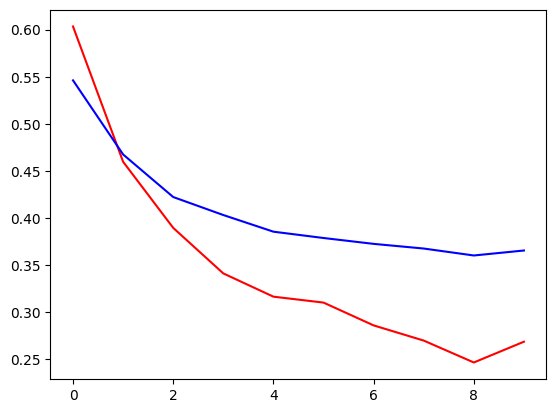

Done!

Training for 10 epochs with learning rate: 0.01
Epoch 1
-------------------------------
loss: 2.305028  [    0/60000]
loss: 2.174147  [ 6400/60000]
loss: 1.807640  [12800/60000]
loss: 1.532810  [19200/60000]
loss: 1.165420  [25600/60000]
loss: 1.039437  [32000/60000]
loss: 1.018623  [38400/60000]
loss: 0.875294  [44800/60000]
loss: 0.879659  [51200/60000]
loss: 0.808442  [57600/60000]
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.793218 

Epoch 2
-------------------------------
loss: 0.795030  [    0/60000]
loss: 0.846376  [ 6400/60000]
loss: 0.576975  [12800/60000]
loss: 0.785442  [19200/60000]
loss: 0.674387  [25600/60000]
loss: 0.637084  [32000/60000]
loss: 0.712442  [38400/60000]
loss: 0.685313  [44800/60000]
loss: 0.706451  [51200/60000]
loss: 0.638782  [57600/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.632514 

Epoch 3
-------------------------------
loss: 0.564046  [    0/60000]
loss: 0.651614  [ 6400/60000]
loss: 0.432722  [12800/60000]
loss: 0.669484  [19200/60000]
l

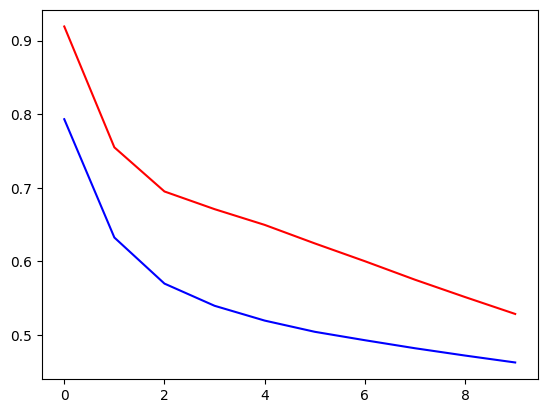

Done!

Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.304691  [    0/60000]
loss: 2.291551  [ 6400/60000]
loss: 2.272370  [12800/60000]
loss: 2.263115  [19200/60000]
loss: 2.261454  [25600/60000]
loss: 2.226220  [32000/60000]
loss: 2.231131  [38400/60000]
loss: 2.194508  [44800/60000]
loss: 2.194481  [51200/60000]
loss: 2.164686  [57600/60000]
Test Error: 
 Accuracy: 45.0%, Avg loss: 2.153214 

Epoch 2
-------------------------------
loss: 2.166766  [    0/60000]
loss: 2.153075  [ 6400/60000]
loss: 2.093805  [12800/60000]
loss: 2.102123  [19200/60000]
loss: 2.072922  [25600/60000]
loss: 2.012287  [32000/60000]
loss: 2.032425  [38400/60000]
loss: 1.951991  [44800/60000]
loss: 1.958705  [51200/60000]
loss: 1.892366  [57600/60000]
Test Error: 
 Accuracy: 58.4%, Avg loss: 1.880416 

Epoch 3
-------------------------------
loss: 1.920475  [    0/60000]
loss: 1.884442  [ 6400/60000]
loss: 1.765658  [12800/60000]
loss: 1.797194  [19200/60000]


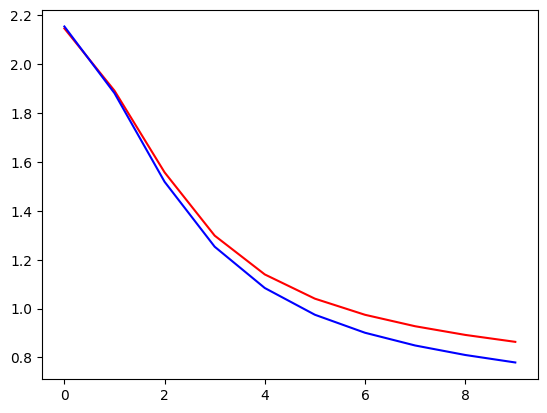

Done!



In [41]:
#Train and test the model
epochs = 10

learning_rates = [1, 1e-1, 1e-2, 1e-3]

for rate in learning_rates:
    print(f"Training for {epochs} epochs with learning rate: {rate}")
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=rate)

    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss, _ = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

    plt.plot(np.array(train_losses), 'r')
    plt.plot(np.array(test_losses), 'b')
    plt.show()

    print("Done!\n")

|Lr|Accuracy|
|---|---|
|1   |    10%  |
|0.1|     87.5%   |
|0.01|     83.3%    |
|0.001  |    70.3%  |

## 1.3

Training with learning rate: 0.01 until reaching 85% accuracy
Epoch 1
-------------------------------
loss: 2.310285  [    0/60000]
loss: 2.175589  [ 6400/60000]
loss: 1.858122  [12800/60000]
loss: 1.549233  [19200/60000]
loss: 1.163300  [25600/60000]
loss: 1.056977  [32000/60000]
loss: 1.012100  [38400/60000]
loss: 0.869220  [44800/60000]
loss: 0.870842  [51200/60000]
loss: 0.804926  [57600/60000]
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.789787 

Epoch 2
-------------------------------
loss: 0.785738  [    0/60000]
loss: 0.840904  [ 6400/60000]
loss: 0.589798  [12800/60000]
loss: 0.779425  [19200/60000]
loss: 0.664690  [25600/60000]
loss: 0.638726  [32000/60000]
loss: 0.711833  [38400/60000]
loss: 0.682911  [44800/60000]
loss: 0.703423  [51200/60000]
loss: 0.630932  [57600/60000]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.629330 

Epoch 3
-------------------------------
loss: 0.551252  [    0/60000]
loss: 0.648583  [ 6400/60000]
loss: 0.440248  [12800/60000]
loss: 0.659268  [19200/6

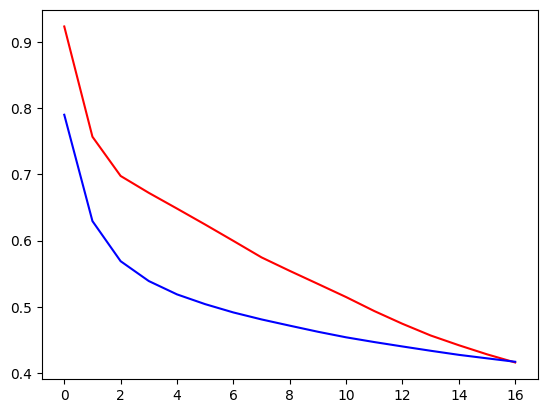

Got accuracy 85.1% in 17 epochs
Training with learning rate: 0.001 until reaching 85% accuracy
Epoch 1
-------------------------------
loss: 2.300782  [    0/60000]
loss: 2.289248  [ 6400/60000]
loss: 2.266873  [12800/60000]
loss: 2.264018  [19200/60000]
loss: 2.245072  [25600/60000]
loss: 2.217081  [32000/60000]
loss: 2.225930  [38400/60000]
loss: 2.189763  [44800/60000]
loss: 2.179140  [51200/60000]
loss: 2.156408  [57600/60000]
Test Error: 
 Accuracy: 45.5%, Avg loss: 2.146119 

Epoch 2
-------------------------------
loss: 2.154651  [    0/60000]
loss: 2.146051  [ 6400/60000]
loss: 2.083194  [12800/60000]
loss: 2.101009  [19200/60000]
loss: 2.054467  [25600/60000]
loss: 1.986397  [32000/60000]
loss: 2.019450  [38400/60000]
loss: 1.934837  [44800/60000]
loss: 1.928802  [51200/60000]
loss: 1.869906  [57600/60000]
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.863098 

Epoch 3
-------------------------------
loss: 1.897873  [    0/60000]
loss: 1.872102  [ 6400/60000]
loss: 1.746677  [1280

KeyboardInterrupt: 

In [42]:
#Train and test the model
learning_rates = [1e-2, 1e-3]

for rate in learning_rates:
    print(f"Training with learning rate: {rate} until reaching 85% accuracy")
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=rate)

    train_losses = []
    test_losses = []

    epoch = 0
    while True:
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss, accuracy = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if accuracy >= 0.85:
            break
        
        epoch += 1

    plt.plot(np.array(train_losses), 'r')
    plt.plot(np.array(test_losses), 'b')
    plt.show()

    print(f"Got accuracy {(100*accuracy):>0.1f}% in {epoch + 1} epochs")

In [ ]:
rate = 1
print(f"Training with learning rate: {rate} until reaching 85% accuracy")
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

epoch = 0
while True:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if accuracy >= 0.85:
        break
    
    epoch += 1

plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

print(f"Got accuracy {(100*accuracy):>0.1f}% in {epoch + 1} epochs")

Training with learning rate: 1 until reaching 85% accuracy
Epoch 1
-------------------------------
loss: 2.313781  [    0/60000]
loss: 2.286547  [ 6400/60000]
loss: 2.312774  [12800/60000]
loss: 2.304624  [19200/60000]
loss: 2.280077  [25600/60000]
loss: 2.339064  [32000/60000]
loss: 3.201489  [38400/60000]
loss: 1.692389  [44800/60000]
loss: 1.734655  [51200/60000]
loss: 3.663614  [57600/60000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.759443 

Epoch 2
-------------------------------
loss: 1.784747  [    0/60000]
loss: 1.698590  [ 6400/60000]
loss: 1.800177  [12800/60000]
loss: 2.255895  [19200/60000]
loss: 2.003374  [25600/60000]
loss: 1.745313  [32000/60000]
loss: 1.663368  [38400/60000]
loss: 1.609096  [44800/60000]
loss: 1.719107  [51200/60000]
loss: 1.698630  [57600/60000]
Test Error: 
 Accuracy: 19.8%, Avg loss: 1.727040 

Epoch 3
-------------------------------
loss: 1.861264  [    0/60000]
loss: 1.686961  [ 6400/60000]
loss: 1.739428  [12800/60000]
loss: 1.788330  [19200/6000

KeyboardInterrupt: 

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.300169  [    0/60000]
loss: 2.280763  [ 6400/60000]
loss: 2.249119  [12800/60000]
loss: 2.246641  [19200/60000]
loss: 2.218433  [25600/60000]
loss: 2.170005  [32000/60000]
loss: 2.190795  [38400/60000]
loss: 2.140498  [44800/60000]
loss: 2.136901  [51200/60000]
loss: 2.084907  [57600/60000]
Test Error: 
 Accuracy: 51.6%, Avg loss: 2.079782 

Epoch 2
-------------------------------
loss: 2.095179  [    0/60000]
loss: 2.079972  [ 6400/60000]
loss: 1.995495  [12800/60000]
loss: 2.023554  [19200/60000]
loss: 1.935881  [25600/60000]
loss: 1.860414  [32000/60000

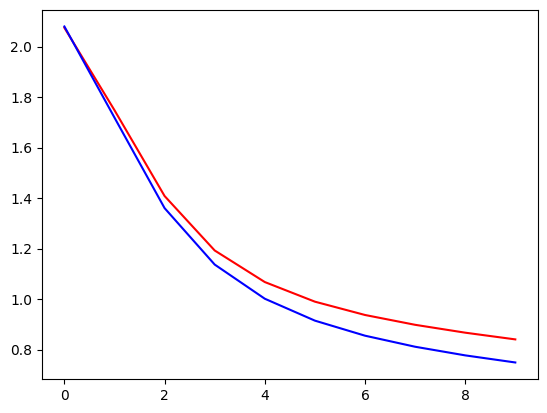

Done!



In [43]:
#1.5

# WIDE

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

#Train and test the model
epochs = 10
rate = 1e-3

print(f"Training for {epochs} epochs with learning rate: {rate}")
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, _ = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

print("Done!\n")

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)
Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.302104  [    0/60000]
loss: 2.301270  [ 6400/60000]
loss: 2.301379  [12800/60000]
loss: 2.301877  [19200/60000]
loss: 2.300066  [25600/60000]
loss: 2.302263  [32000/60000]
loss: 2.299258  [38400/60000]
loss: 2.301517  [44800/60000]
loss: 2.297601  [51200/60000]
loss: 2.296129  [57600/60000]
Test Error: 
 Accuracy: 17.9%, Avg loss: 2.297879 

Epoch 2
-------------------------------
loss: 2.296856  [    0/600

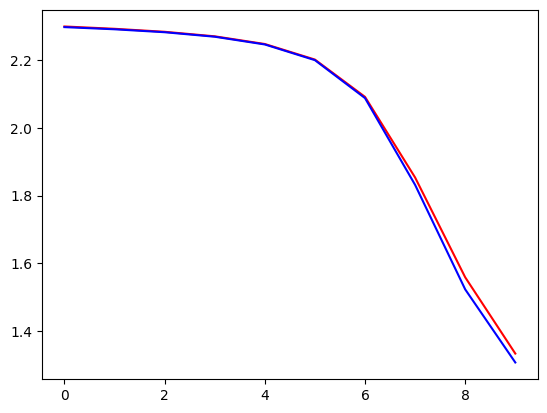

Done!



In [ ]:
#1.5

# DEEP

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

#Train and test the model
epochs = 10
rate = 1e-3

print(f"Training for {epochs} epochs with learning rate: {rate}")
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, _ = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

print("Done!\n")

In [59]:
# 1.6
# TODO: Should this be happening during the training process?

# TODO Where does the input come from?
input = torch.randn(1, 1, 28, 28)
output = model(input.to(device))

# TODO: Where do the targets come from?
target = torch.randn(10).to(device)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output

loss = loss_fn(output, target)
loss.backward()

# TODO: Update model to be CNN? Nope this is question 7 actually
# TODO: Specify layers individually on the model instead of in ReLU stack?
print(model.linear_relu_stack[0].weight.grad.mean())

tensor(-2.3151e-05, device='cuda:0')


In [40]:
# 1.7

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        #self.linear_relu_stack = nn.Sequential(
        #      nn.Linear(32*32*3, 512),
        #      nn.ReLU(),
        #      nn.Linear(512, 512),
        #      nn.ReLU(),
        #      nn.Linear(512, 10)
        #) 
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.flatten(x)
        #x = self.linear_relu_stack(x)
        return x


net = Net()
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.requires_grad_()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Finished Training
Accuracy of the network on the 10000 test images: 89 %


In [41]:
import numpy as np

def compute_mean_gradients(model):
    mean_grads = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            mean_grads[name] = param.grad.abs().mean().item()
    return mean_grads

mean_grads = compute_mean_gradients(net)
for name, mean_grad in mean_grads.items():
    print(f'{name}: {mean_grad:.4f}')

conv1.weight: 0.0174
conv1.bias: 0.0239
conv2.weight: 0.0130
conv2.bias: 0.0100
fc1.weight: 0.0059
fc1.bias: 0.0027
fc2.weight: 0.0059
fc2.bias: 0.0041
fc3.weight: 0.0091
fc3.bias: 0.0049
